In [104]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [105]:
label_encoder = None 

def get_np_array_ordinal(file_name):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OrdinalEncoder()
        # label_encoder = OrdinalEncoder(sparse_output = False)
        label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

def get_np_array_one_hot(file_name):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OneHotEncoder(sparse_output = False)
        label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

In [106]:
class DTNode:
    # Decision Tree Node

    def __init__(self, depth):
        self.depth = depth
        self.value = 0
        self.is_leaf = False
        self.column = None
        self.children = {}
        self.type = None
        self.median = None


    def get_children(self, X):
        '''
        Args:
            X: A single example np array [num_features]
        Returns:
            child: A DTNode
        '''
        if self.is_leaf:
            return None
        if self.type == 'cat':
            if X[self.column] in self.children:
                return self.children[X[self.column]]
            else:
                return None
        if self.type == 'cont':
            if X[self.column] <= self.median:
                return self.children[0]
            else:
                return self.children[1]
        return None


class DTTree:

    def __init__(self):
        #Tree root should be DTNode
        self.root = None


    def fit(self, X, y, types, max_depth = 10):
        '''
        Makes decision tree

        Args:
            X: numpy array of data [num_samples, num_features]
            y: numpy array of classes [num_samples, 1]
            types: list of [num_features] with types as: cat, cont
                eg: if num_features = 4, and last 2 features are continious then
                    types = ['cat','cat','cont','cont']
            max_depth: maximum depth of tree
        Returns:
            None
        '''
        self.root = DTNode(0)
        self.root = self.__fit(self.root, X, y, types, max_depth)
        return None

    def __fit(self, node: DTNode, X: np.ndarray, y: np.ndarray, types: list, max_depth: int) -> DTNode:
        '''
        Recursively makes decision tree

        Args:
            node: DTNode
            X: numpy array of data [num_samples, num_features]
            y: numpy array of classes [num_samples, 1]
            types: list of [num_features] with types as: cat, cont
                eg: if num_features = 4, and last 2 features are continious then
                    types = ['cat','cat','cont','cont']
            max_depth: maximum depth of tree
        Returns:
            node: DTNode
        '''

        node.value = stats.mode(y)[0][0]

        if(node.depth == max_depth):
            node.is_leaf = True
            return node
        
        # if all y are same
        if(np.unique(y).size == 1):
            node.is_leaf = True
            return node
        
        # choose the attribute which results in the highest mutual information

        # mutual information
        mutual_info = []
        for i in range(X.shape[1]):
            if(types[i] == 'cat'):
                mutual_info.append(self.__mutual_info_cat(X[:,i], y[:,0]))
            else:
                mutual_info.append(self.__mutual_info_cont(X[:,i], y[:,0]))

        # split on the attribute which results in the highest mutual information
        node.column = np.argmax(mutual_info)
        node.type = types[node.column]
        x_split = X[:,node.column]

        # split on the attribute
        if(node.type == 'cat'):
            node.children = {}
            for i in np.unique(x_split):
                idx = x_split == i
                node.children[i] = DTNode(node.depth+1)
                node.children[i] = self.__fit(node.children[i], X[idx], y[idx], types, max_depth)
        else:
            node.children = {}
            node.median = np.median(x_split)
            less = x_split <= node.median
            node.children[0] = DTNode(node.depth+1)
            node.children[0] = self.__fit(node.children[0], X[less], y[less], types, max_depth)
            node.children[1] = DTNode(node.depth+1)
            node.children[1] = self.__fit(node.children[1], X[~less], y[~less], types, max_depth)

        return node
    
    def __mutual_info_cat(self, x: np.ndarray, y: np.ndarray) -> float:
        '''
        Calculates mutual information between x and y, when x is categorical attribute

        Args:
            x: numpy array of data [num_samples]
            y: numpy array of classes [num_samples]
        Returns:
            mutual_info: float
        '''
        mutual_info = 0
        for i in np.unique(x):
            mutual_info += np.sum(x == i) / x.size * self.__entropy(y[x == i])
        mutual_info = self.__entropy(y) - mutual_info
        return mutual_info
    
    def __mutual_info_cont(self, x: np.ndarray, y: np.ndarray) -> float:
        '''
        Calculates mutual information between x and y, when x is continuous attribute

        Args:
            x: numpy array of data [num_samples]
            y: numpy array of classes [num_samples]
        Returns:
            mutual_info: float
        '''
        mutual_info = 0
        median = np.median(x)
        less = x <= median
        mutual_info += np.sum(less) / x.size * self.__entropy(y[less])
        mutual_info += np.sum(~less) / x.size * self.__entropy(y[~less])
        mutual_info = self.__entropy(y) - mutual_info
        return mutual_info
    
    def __entropy(self, y: np.ndarray) -> float:
        '''
        Calculates entropy of y

        Args:
            y: numpy array of classes [num_samples]
        Returns:
            entropy: float
        '''
        entropy = 0
        for i in np.unique(y):
            p = np.sum(y == i) / y.size
            entropy -= p * np.log2(p)
        return entropy

    def __call__(self, X):
        '''
        Predicted classes for X

        Args:
            X: numpy array of data [num_samples, num_features]
        Returns:
            y: [num_samples, 1] predicted classes
        '''
        y = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            y[i] = self.__call(self.root, X[i])
        return y
    
    def __call(self, node: DTNode, X: np.ndarray) -> float:
        '''
        Predicted class for a single example X

        Args:
            node: DTNode
            X: numpy array of data [num_features]
        Returns:
            y: float predicted class
        '''
        child = node.get_children(X)
        if child is None:
            return node.value
        return self.__call(child, X)
    
    def post_prune(self, X_val, y_val):
        pass

In [107]:
X_train,y_train = get_np_array_ordinal('train.csv')
X_test, y_test = get_np_array_ordinal('test.csv')
types = ['cat','cat','cat','cat','cat','cont','cat','cat','cat','cont','cont','cont']

In [108]:
depths = [5, 10, 15, 20, 25]
train_acc = []
test_acc = []
for depth in depths:
    tree = DTTree()
    tree.fit(X_train, y_train, types, depth)
    train_acc.append(100*np.sum(tree(X_train) == y_train) / y_train.size)
    test_acc.append(100*np.sum(tree(X_test) == y_test) / y_test.size)

In [109]:
only_win_acc = 100*np.sum(y_test == 1) / y_test.size
only_lose_acc = 100*np.sum(y_test == 0) / y_test.size
df = pd.DataFrame({'Depth':depths, 'Train accuracy (%)':train_acc, 'Test accuracy (%)':test_acc}).round(4)
display(df)
print(f'Only win accuracy: {only_win_acc:.4f} %')
print(f'Only lose accuracy: {only_lose_acc:.4f} %')

,Depth,Train accuracy (%),Test accuracy (%)
0,5,88.5652,57.6008
1,7,96.9720,59.8759
2,10,99.6295,60.1861
3,15,99.6934,60.1861
4,20,99.6934,60.1861
5,25,99.6934,60.1861


Only win accuracy: 49.6381 %
Only lose accuracy: 50.3619 %


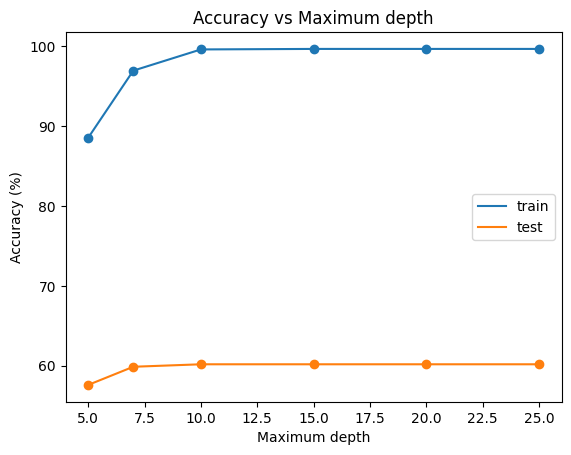

In [110]:
plt.plot(depths, train_acc, label = 'train')
plt.plot(depths, test_acc, label = 'test')
plt.scatter(depths, train_acc)
plt.scatter(depths, test_acc)
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Maximum depth')
plt.legend()
plt.savefig('plots/q1a.png')

In [111]:
label_encoder = None
X_train,y_train = get_np_array_one_hot('train.csv')
X_test, y_test = get_np_array_one_hot('test.csv')
types = ['cat','cat','cat','cat','cat','cont','cat','cat','cat','cont','cont','cont']
while len(types) != X_train.shape[1]:
    types = ['cat'] + types

In [112]:
depths = [15,20,25,35,45,75,100]
train_acc = []
test_acc = []
for depth in depths:
    tree = DTTree()
    tree.fit(X_train, y_train, types, depth)
    train_acc.append(100*np.sum(tree(X_train) == y_train) / y_train.size)
    test_acc.append(100*np.sum(tree(X_test) == y_test) / y_test.size)

In [113]:
df = pd.DataFrame({'Depth':depths, 'Train accuracy (%)':train_acc, 'Test accuracy (%)':test_acc}).round(4)
display(df)

,Depth,Train accuracy (%),Test accuracy (%)
0,15,70.5379,55.8428
1,20,78.7147,60.1861
2,25,84.8345,61.7373
3,35,92.4492,61.4271
4,45,99.0034,61.1169
5,75,99.7956,61.6339
6,100,99.7956,61.6339


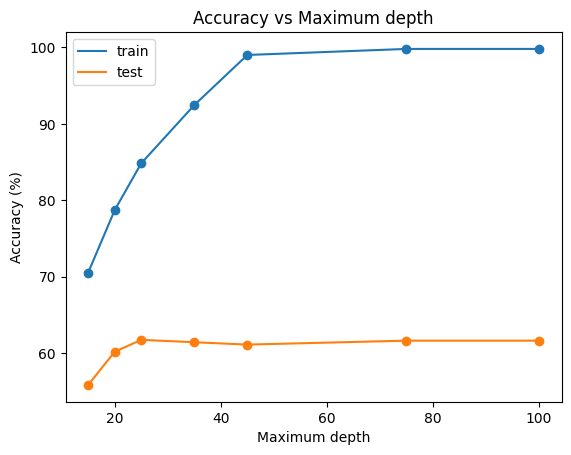

In [114]:
plt.clf()
plt.plot(depths, train_acc, label = 'train')
plt.plot(depths, test_acc, label = 'test')
plt.scatter(depths, train_acc)
plt.scatter(depths, test_acc)
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Maximum depth')
plt.legend()
plt.savefig('plots/q1b.png')